In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

2023-04-19 01:23:09.991086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 01:23:10.049479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 01:23:10.050409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 01:23:10.930111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = yf.download("Gold", start="2018-01-01", end="2022-01-01")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,14.65,15.24,14.61,15.20,13.524044,15223200
2018-01-03,15.24,15.27,14.74,15.00,13.346094,15155900
2018-01-04,15.03,15.05,14.79,15.03,13.372787,8936100
2018-01-05,14.99,15.00,14.87,14.95,13.301606,6515600
2018-01-08,14.88,14.95,14.64,14.74,13.114761,8362600


In [3]:
data.drop(columns=["Adj Close"])

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,14.650000,15.240000,14.610000,15.200000,15223200
2018-01-03,15.240000,15.270000,14.740000,15.000000,15155900
2018-01-04,15.030000,15.050000,14.790000,15.030000,8936100
2018-01-05,14.990000,15.000000,14.870000,14.950000,6515600
2018-01-08,14.880000,14.950000,14.640000,14.740000,8362600
...,...,...,...,...,...
2021-12-27,18.500000,18.580000,18.270000,18.410000,11740600
2021-12-28,18.450001,18.670000,18.309999,18.370001,10310100
2021-12-29,18.240000,18.660000,18.219999,18.400000,17290100


In [4]:
target = data["High"]
target = target.to_numpy()
data.drop(columns="High", inplace=True)

In [5]:
scaler_data = StandardScaler()
scaler_target = StandardScaler()

data = scaler_data.fit_transform(data)
data = pd.DataFrame(data, columns=["date", "open", "low", "close", "volume"])

target = scaler_target.fit_transform(target.reshape(-1, 1))
target = pd.DataFrame(target, columns=["max"])

data.drop(columns=["date"], inplace=True)

In [6]:
with open('scaler_data.pkl', 'wb') as f:
    pickle.dump(scaler_data, f)

with open('scaler_target.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)

In [7]:
target.head()

,max
0,-0.618247
1,-0.612653
2,-0.653680
3,-0.663005
4,-0.672329


In [8]:
def prepare_data(data, target, lookback):
    x = []
    y = []
    for i in range(len(data) - lookback):
        x.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(x), np.array(y)

lookback = 7
x, y = prepare_data(data.values, target.values, lookback)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
model = Sequential([
    LSTM(64, input_shape=(lookback, x_train.shape[2])),
    Dense(64, activation="relu"),
    Dense(1)
])

2023-04-19 01:23:12.488102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-19 01:23:12.753959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:23:12.756530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:23:12.758353: I tensorflow/core/com

In [11]:
filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [12]:
model.compile(optimizer='adam', loss='mse', metrics=["mse"])

In [13]:
history = model.fit(x_train, y_train, epochs=64, batch_size=16, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/64


2023-04-19 01:23:13.166692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:23:13.169147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:23:13.170776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/50 [===========================>..] - ETA: 0s - loss: 0.1317 - mse: 0.1317

2023-04-19 01:23:15.066962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:23:15.068859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:23:15.070256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.02361, saving model to model.h5
50/50 [==============================] - 2s 15ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 2/64
48/50 [===========================>..] - ETA: 0s - loss: 0.0182 - mse: 0.0182
Epoch 2: val_loss improved from 0.02361 to 0.01786, saving model to model.h5
50/50 [==============================] - 0s 6ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 3/64
48/50 [===========================>..] - ETA: 0s - loss: 0.0144 - mse: 0.0144
Epoch 3: val_loss improved from 0.01786 to 0.01531, saving model to model.h5
50/50 [==============================] - 0s 6ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 4/64
47/50 [===========================>..] - ETA: 0s - loss: 0.0129 - mse: 0.0129
Epoch 4: val_loss improved from 0.01531 to 0.01465, saving model to model.h5
50/50 [==============================] - 0s 6ms/step - loss: 0.0126 - 

48/50 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 0.0046
Epoch 31: val_loss did not improve from 0.00759
50/50 [==============================] - 0s 5ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 32/64
48/50 [===========================>..] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 32: val_loss did not improve from 0.00759
50/50 [==============================] - 0s 6ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 33/64
47/50 [===========================>..] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 33: val_loss did not improve from 0.00759
50/50 [==============================] - 0s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 34/64
49/50 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0050
Epoch 34: val_loss did not improve from 0.00759
50/50 [==============================] - 0s 5ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0080 - 

Epoch 63/64
49/50 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 63: val_loss did not improve from 0.00725
50/50 [==============================] - 0s 5ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 64/64
48/50 [===========================>..] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 64: val_loss did not improve from 0.00725
50/50 [==============================] - 0s 6ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0075 - val_mse: 0.0075


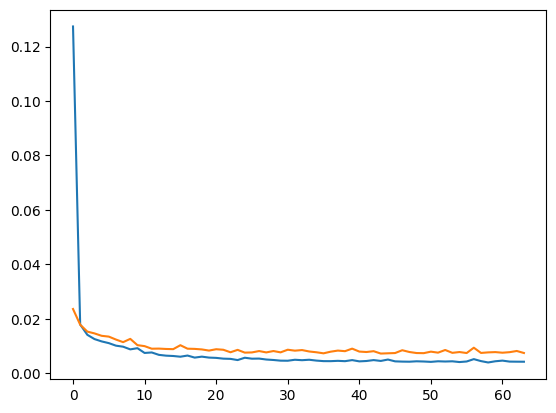

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [15]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075


[0.0074523077346384525, 0.0074523077346384525]

In [16]:
result = model.predict(x_test[85].reshape(1, x_test[0].shape[0], x_test[0].shape[1]))

1/1 [==============================] - 0s 396ms/step


2023-04-19 01:23:33.912826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:23:33.914947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:23:33.916417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
with open('scaler_target.pkl', 'rb') as f:
    scaler_target = pickle.load(f)

In [18]:
result = scaler_target.inverse_transform(result)
print(result)

[[19.803875]]


In [19]:
answer = scaler_target.inverse_transform(y_test[85].reshape(1, y_test[0].shape[0]))
print(answer)

[[17.97999954]]


In [22]:
from keras.models import load_model

model = load_model('model.h5')

2023-04-19 01:24:13.587651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:24:13.589894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:24:13.591475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus